# Data Aug Experiment for Synthetic Face Data

MobileNetV2 with Synthetic Face Data

Dataset from [Kaggle](https://www.kaggle.com/datasets/allexmendes/synthetic-gaze-and-face-segmentation/data)

This notebook trains a gaze prediction model using a dual-input CNN:
- **Input 1**: 224×224 face image (see the other notebook for preprocessing)
- **Input 2**: 4D pupil coordinate vector (`L_Pupil` and `R_Pupil`)
- **Output**: 2D normalized gaze direction vector (from `ImageEyesGazeDirection` annotation)

We use MobileNetV2 as the backbone for the visual stream and concatenate it with pupil coordinates before regression.

In [2]:
import os
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))
import albumentations as A
from tensorflow.keras.utils import Sequence

TF version: 2.19.0
GPUs: []


## Load Dataset with Normalized Pupil Coordinates and Gaze Vectors

In [8]:
%pwd

'/home/ste/Documents/gesture-gaze-extension/notebooks'

In [ ]:
PROJ_DIR = '/home/ste/Documents/gesture-gaze-extension'
DATA_DIR = os.path.join(PROJ_DIR, 'datasets')
IMG_DIR = os.path.join(DATA_DIR, 'SynthGazeProcessed/images')
JSON_DIR = os.path.join(DATA_DIR, 'SynthGazeProcessed/json')
BEST_MODEL_PATH = os.path.join(PROJ_DIR, 'models/mobilenetv2_synth_best.keras')
LAST_MODEL_PATH = os.path.join(PROJ_DIR, 'models/mobilenetv2_synth_last.keras')
TF_SAVE_MODEL_PATH = os.path.join(PROJ_DIR, 'models/tf_synth_save')
TFJS_MODEL_PATH = os.path.join(PROJ_DIR, 'models/tfjs_synth_model')
IMG_SIZE = (224, 224)
SEED = 42028

def load_dataset():
    images = []
    pupils = []
    labels = []

    for fname in sorted(os.listdir(JSON_DIR)):
        if not fname.endswith('.json'):
            continue

        json_path = os.path.join(JSON_DIR, fname)
        img_path = os.path.join(IMG_DIR, fname.replace('.json', '.png'))

        with open(json_path, 'r') as f:
            data = json.load(f)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0

        l_pupil = data["Landmarks"]["L_Pupil"]
        r_pupil = data["Landmarks"]["R_Pupil"]

        # Normalize pupil coords
        norm_pupils = [
            l_pupil[0] / IMG_SIZE[0], l_pupil[1] / IMG_SIZE[1],
            r_pupil[0] / IMG_SIZE[0], r_pupil[1] / IMG_SIZE[1]
        ]

        gaze = data["Overall"]["ImageEyesGazeDirection"]

        images.append(img)
        pupils.append(norm_pupils)
        labels.append(gaze)

    return np.array(images), np.array(pupils), np.array(labels)


X_img, X_pupil, y = load_dataset()
X_img_train, X_img_val, X_pupil_train, X_pupil_val, y_train, y_val = train_test_split(
    X_img, X_pupil, y, test_size=0.2, random_state=SEED)

In [388]:
print(X_pupil_train.shape)  # should be (N, 4)
print(X_img_train.shape)    # should be (N, 224, 224, 3)

(3200, 4)
(3200, 224, 224, 3)


In [389]:
def draw_gaze_from_pupils(img, gaze_vec, l_pupil, r_pupil, color=(0, 255, 0), scale=50):
    img = img.copy()
    l_pt = (round(l_pupil[0]), round(l_pupil[1]))
    r_pt = (round(r_pupil[0]), round(r_pupil[1]))

    l_end = (round(l_pt[0] + gaze_vec[0] * scale), round(l_pt[1] + gaze_vec[1] * scale))
    r_end = (round(r_pt[0] + gaze_vec[0] * scale), round(r_pt[1] + gaze_vec[1] * scale))

    cv2.arrowedLine(img, l_pt, l_end, color, 2, tipLength=0.1)
    cv2.arrowedLine(img, r_pt, r_end, (0, 0, 255), 2, tipLength=0.1)  # red from right eye
    return img

In [390]:
class GazeTrainingGenerator(Sequence):
    def __init__(self, X_img, X_pupil, y, augmentor, batch_size=32, shuffle=True):
        self.X_img = X_img
        self.X_pupil = X_pupil
        self.y = y
        self.augmentor = augmentor
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(X_img))
        self.on_epoch_end()

    def __len__(self):
        return len(self.X_img) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        imgs, pupils, labels = [], [], []

        for i in batch_indices:
            img = self.X_img[i]
            l_x, l_y, r_x, r_y = self.X_pupil[i]
            gaze = self.y[i]

            # De-normalize pupils to pixel space
            l_pupil = [l_x * IMG_SIZE[0], l_y * IMG_SIZE[1]]
            r_pupil = [r_x * IMG_SIZE[0], r_y * IMG_SIZE[1]]

            # Augment
            aug_img, aug_gaze, aug_l_pupil, aug_r_pupil = self.augmentor(img, gaze, l_pupil, r_pupil)
            aug_pupil = [aug_l_pupil, aug_r_pupil]

            imgs.append(aug_img)
            pupils.append(aug_pupil)
            labels.append(aug_gaze)

        return (np.array(imgs), np.array(pupils)), np.array(labels)


In [391]:
class AlbumentationsGazeAugmentor:
    def __init__(self, image_size=224, vector_scale=50):
        self.image_size = image_size
        self.vector_scale = vector_scale
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussNoise(p=0.2)
        ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

    def __call__(self, img, gaze_vector, l_pupil, r_pupil):
        center = np.array([self.image_size / 2, self.image_size / 2])
        endpoint = center + gaze_vector * self.vector_scale
        keypoints = [
            tuple(center), tuple(endpoint),
            tuple(l_pupil), tuple(r_pupil)
        ]

        augmented = self.aug(image=(img * 255).astype(np.uint8), keypoints=keypoints)
        aug_img = augmented["image"].astype(np.float32) / 255.0

        new_center = np.array(augmented["keypoints"][0])
        new_endpoint = np.array(augmented["keypoints"][1])
        new_l_pupil = np.array(augmented["keypoints"][2])
        new_r_pupil = np.array(augmented["keypoints"][3])
        new_l_pupil_norm = [
            new_l_pupil[0] / self.image_size,
            new_l_pupil[1] / self.image_size
        ]
        new_r_pupil_norm = [
            new_r_pupil[0] / self.image_size,
            new_r_pupil[1] / self.image_size
        ]

        vec = new_endpoint - new_center
        norm = np.linalg.norm(vec)
        new_gaze = vec / norm if norm != 0 else gaze_vector

        return aug_img, new_gaze, new_l_pupil_norm, new_r_pupil_norm


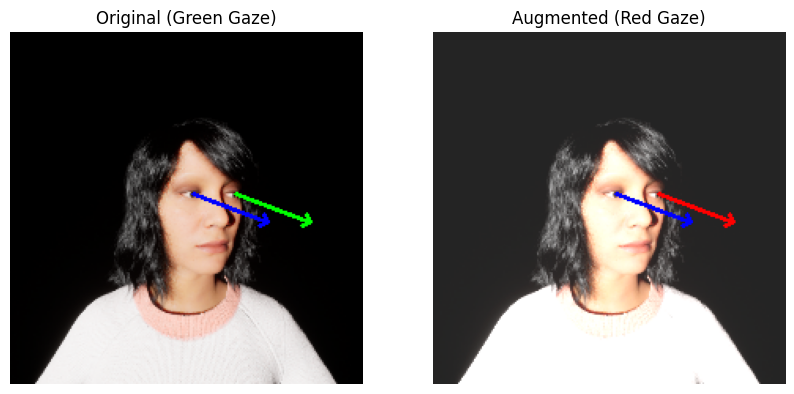

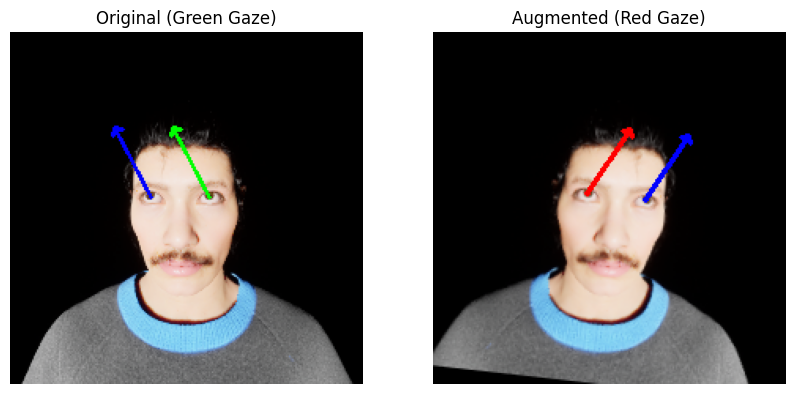

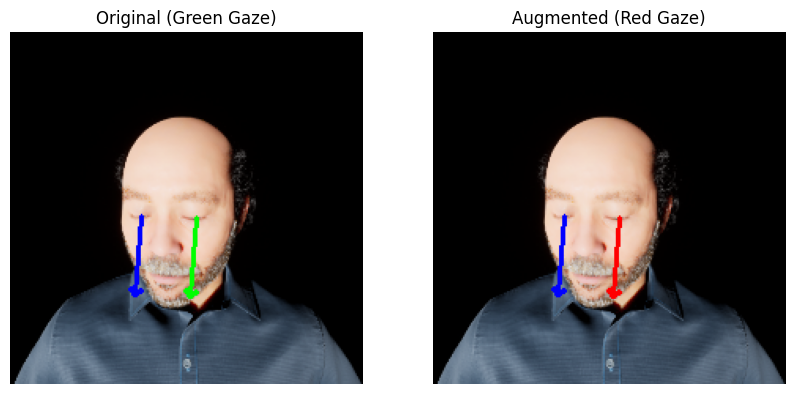

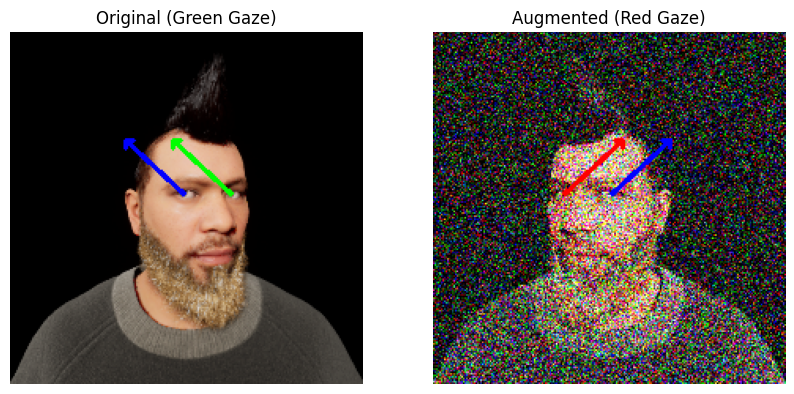

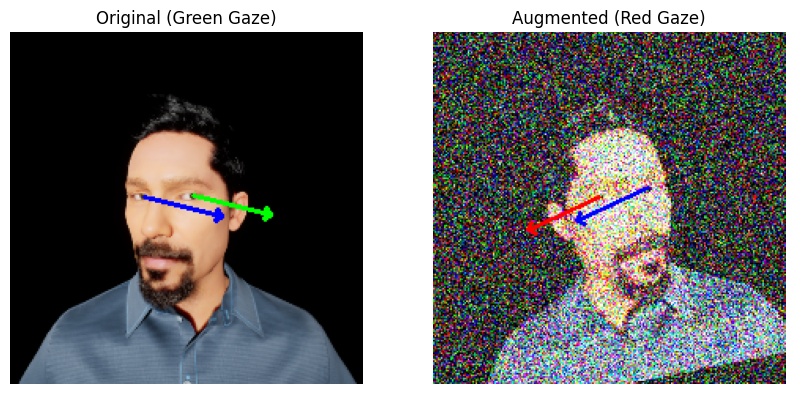

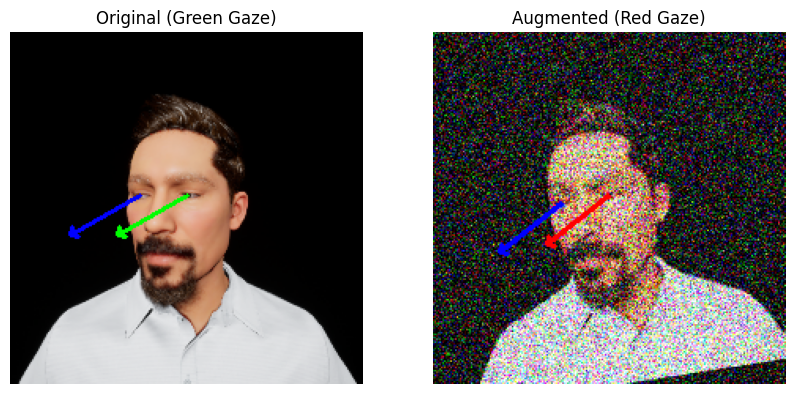

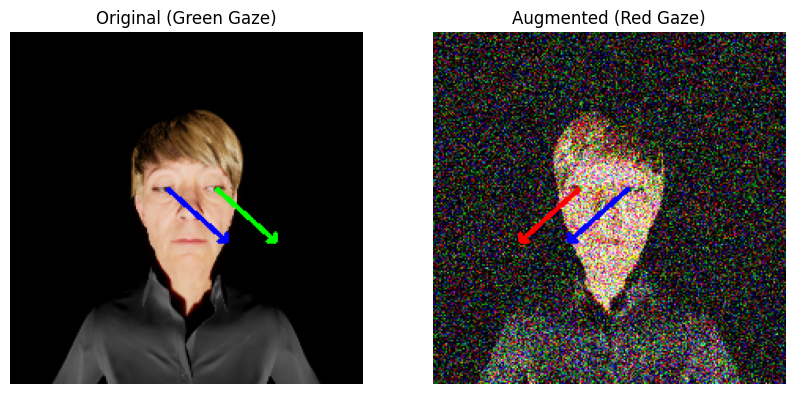

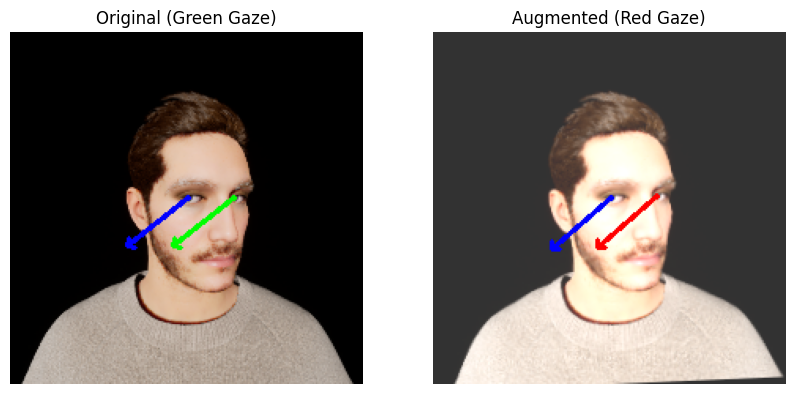

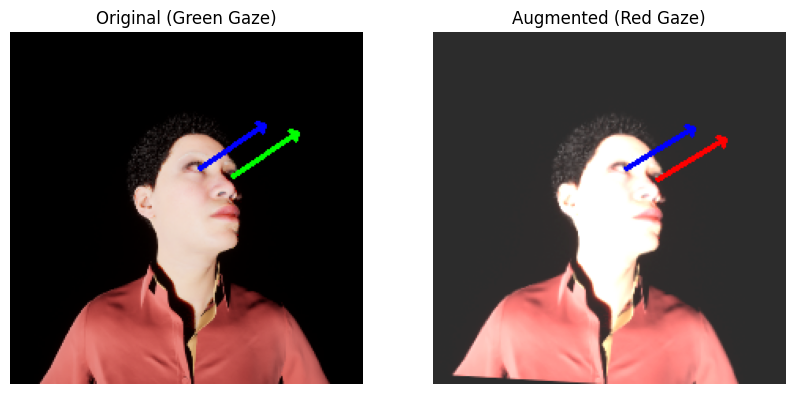

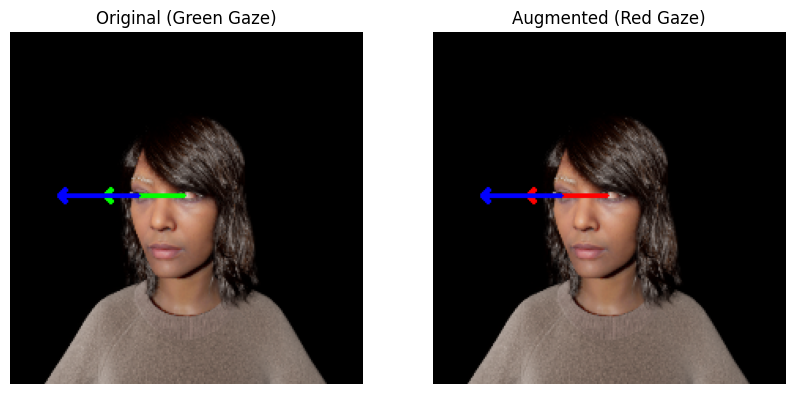

In [401]:
augmentor = AlbumentationsGazeAugmentor()

n = 10
for i in range(n):
    img = (X_img_val[i] * 255).astype(np.uint8)  # actual image from validation set
    true_vec = y_val[i]
    l_x, l_y, r_x, r_y = X_pupil_val[i]
    l_pupil = [l_x*224, l_y*224]
    r_pupil = [r_x*224, r_y*224]

    aug_img, aug_vec, aug_l_pupil, aug_r_pupil = augmentor(X_img_val[i], true_vec, l_pupil, r_pupil)
    aug_img = (aug_img * 255).astype(np.uint8)
    aug_l_pupil = [aug_l_pupil[0]*224, aug_l_pupil[1]*224]
    aug_r_pupil = [aug_r_pupil[0]*224, aug_r_pupil[1]*224]

    vis_img = draw_gaze_from_pupils(img, true_vec, l_pupil, r_pupil, color=(0, 255, 0))
    vis_aug = draw_gaze_from_pupils(aug_img, aug_vec, aug_l_pupil, aug_r_pupil, color=(255, 0, 0))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(vis_img)
    axes[0].set_title("Original (Green Gaze)")
    axes[0].axis("off")

    axes[1].imshow(vis_aug)
    axes[1].set_title("Augmented (Red Gaze)")
    axes[1].axis("off")
    
    plt.show()